I have a classification problem, I will try Logistic regression, KNN classifier and Random forest. After initial assessment of which model is better I will work on tuning the model.

In [7]:
#Loading libraries
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from io import StringIO
from IPython.display import Image  
import pydotplus
from bayes_opt import BayesianOptimization
import datetime
from library.sb_utils import save_file

In [4]:
# Loading data
X_train = pd.read_csv('train_features.csv')
y_train = pd.read_csv('train_target.csv')

X_test = pd.read_csv('test_features.csv')
y_test = pd.read_csv('test_target.csv')

In [3]:
#Checking proportion of classes in target feature
y_train.value_counts(normalize=True)

Status Category
0                  0.855504
1                  0.144496
Name: proportion, dtype: float64

The classes in my target feature are imbalanced. I can't use accuracy as my model assessment metric, because the dumb model that assigns "No cancellation" label to each observation will have accuracy of 85%. I will use recall for 'Status' class = 1 (cancellation) as my main metric. And will keep an eye on recall for 'Status' class = 0. 

## Logistic Regression

In [12]:
# Initializing and fitting the model. I'm using class_weight = 'balanced' to accomodate for imbalanced 
# classes of target feature.

classifier = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', max_iter = 500, C = 1000) #solver = 'newton-cg'
classifier.fit(X_train, y_train)

/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1000, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [13]:
print(f'Accuracy on training data: {accuracy_score(classifier.predict(X_train), y_train):.2f}')
print(f'Accuracy on test data: {accuracy_score(classifier.predict(X_test), y_test):.2f}')

Accuracy on training data: 0.80
Accuracy on test data: 0.79


In [14]:
print("Classification Report for Training Data")
print(classification_report(y_train, classifier.predict(X_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     72030
           1       0.41      0.95      0.57     12166

    accuracy                           0.80     84196
   macro avg       0.70      0.86      0.72     84196
weighted avg       0.91      0.80      0.82     84196



In [15]:
print("Classification Report for Test Data")
print(classification_report(y_test, classifier.predict(X_test)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     31007
           1       0.39      0.93      0.55      5077

    accuracy                           0.79     36084
   macro avg       0.69      0.85      0.71     36084
weighted avg       0.90      0.79      0.82     36084



  Logistic regression model produced pretty good results. Recall for 'Cancelled' on test data is 93%.

## KNN Classifier model

In [3]:
# Changing features to array
X_train2 = np.array(X_train)
y_train2 = np.array(y_train)
X_test2 = np.array(X_test)
y_test2 = np.array(y_test)


In [4]:
# Resampling data set
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train2, y_train2)

In [17]:
# Checking which n_neighbours parameter will produce better accuracy score
test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_resampled,y_resampled)
    
    train_scores.append(knn.score(X_resampled,y_resampled))
    test_scores.append(knn.score(X_test2,y_test2))

In [18]:
# Printing the results
n=1
for score1, score2 in zip(train_scores, test_scores):
    print(f"for {n} neighbours the train score is: {round(score1,3)}, test score is: {round(score2,3)}") 
    n += 1

for 1 neighbours the train score is: 0.995, test score is: 0.827
for 2 neighbours the train score is: 0.982, test score is: 0.837
for 3 neighbours the train score is: 0.949, test score is: 0.784
for 4 neighbours the train score is: 0.948, test score is: 0.799
for 5 neighbours the train score is: 0.915, test score is: 0.752
for 6 neighbours the train score is: 0.917, test score is: 0.77
for 7 neighbours the train score is: 0.889, test score is: 0.73
for 8 neighbours the train score is: 0.895, test score is: 0.749
for 9 neighbours the train score is: 0.871, test score is: 0.712


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

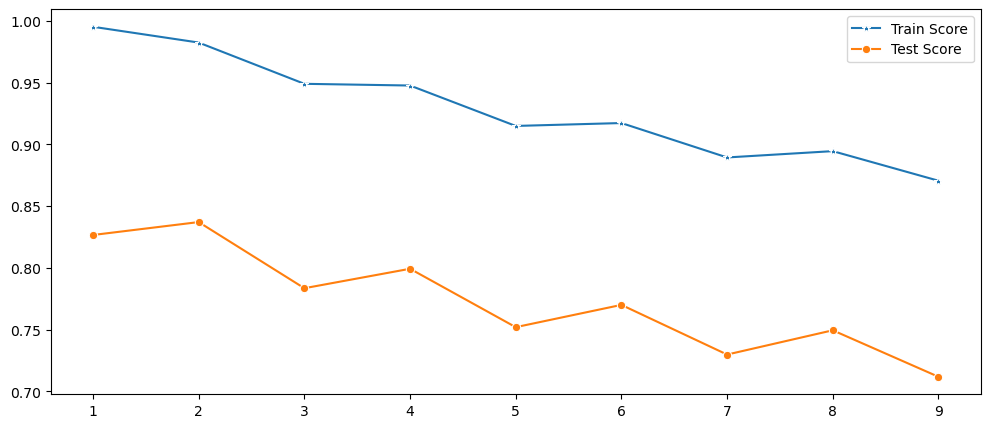

In [19]:
# Plotting the results
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,10),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,10),y=test_scores,marker='o',label='Test Score')

In [20]:
# Max test score has a model with n_neighbours=2
knn = KNeighborsClassifier(2)
knn.fit(X_resampled,y_resampled)
  
train_score = knn.score(X_resampled,y_resampled)
test_score = knn.score(X_test2, y_test2)

print(f"train score: {train_score}, test score: {test_score}")

train score: 0.9824031653477717, test score: 0.837074603702472


In [21]:
y_pred2 = knn.predict(X_test2)

In [22]:
report = classification_report(y_test2, y_pred2)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     31007
           1       0.42      0.42      0.42      5077

    accuracy                           0.84     36084
   macro avg       0.66      0.66      0.66     36084
weighted avg       0.84      0.84      0.84     36084



KNN model produced much worse results - only 42% recall for 'Cancelled'.

## Random Forest Classifier

In [5]:
# Loading unscaled data for better interpretability
X_train_unscaled = pd.read_csv('train_unscaled_features.csv')
X_test_unscaled = pd.read_csv('test_unscaled_features.csv')

In [15]:
# Fitting the model, predicting results, assessing accuracy  

rf = RandomForestClassifier(class_weight = 'balanced',n_estimators=300, n_jobs=-1)
rf.fit(X_train_unscaled, y_train)

y_pred3 = rf.predict(X_test_unscaled)

ac = accuracy_score(y_test, y_pred3)
print(f"Test accuracy score: {ac}")


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test accuracy score: 0.9097938144329897


In [16]:
# Printing classification report

cr = classification_report(y_test, y_pred3)
print('Classification report:')
print(cr)

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     31007
           1       0.76      0.53      0.62      5077

    accuracy                           0.91     36084
   macro avg       0.84      0.75      0.79     36084
weighted avg       0.90      0.91      0.90     36084



Random Forest model produced higher accuracy two previous models (91%), but it's quite bad at predicting 'Cancelled' orders (only 53% recall).

## Decision Tree

In [13]:
# Entropy model
entr_model = tree.DecisionTreeClassifier(class_weight = 'balanced',criterion="entropy",max_depth=3)
entr_model.fit(X_train_unscaled, y_train)
 
y_pred4 = entr_model.predict(X_test_unscaled)
y_pred4 = pd.Series(y_pred4)

entr_model

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3)

In [14]:
cr4 = classification_report(y_test, y_pred4)
print('Classification report:')
print(cr4)

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     31007
           1       0.37      0.98      0.54      5077

    accuracy                           0.76     36084
   macro avg       0.68      0.85      0.69     36084
weighted avg       0.91      0.76      0.80     36084



In [10]:
# Gini model
gini_model = tree.DecisionTreeClassifier(class_weight = 'balanced', criterion="gini",max_depth=3)
gini_model.fit(X_train_unscaled,y_train) 

y_pred5 = gini_model.predict(X_test_unscaled) 
y_pred5 = pd.Series(y_pred5)

gini_model

DecisionTreeClassifier(class_weight='balanced', max_depth=3)

In [11]:
cr5 = classification_report(y_test, y_pred5)
print('Classification report:')
print(cr5)

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     31007
           1       0.37      0.98      0.54      5077

    accuracy                           0.76     36084
   macro avg       0.68      0.85      0.69     36084
weighted avg       0.91      0.76      0.80     36084



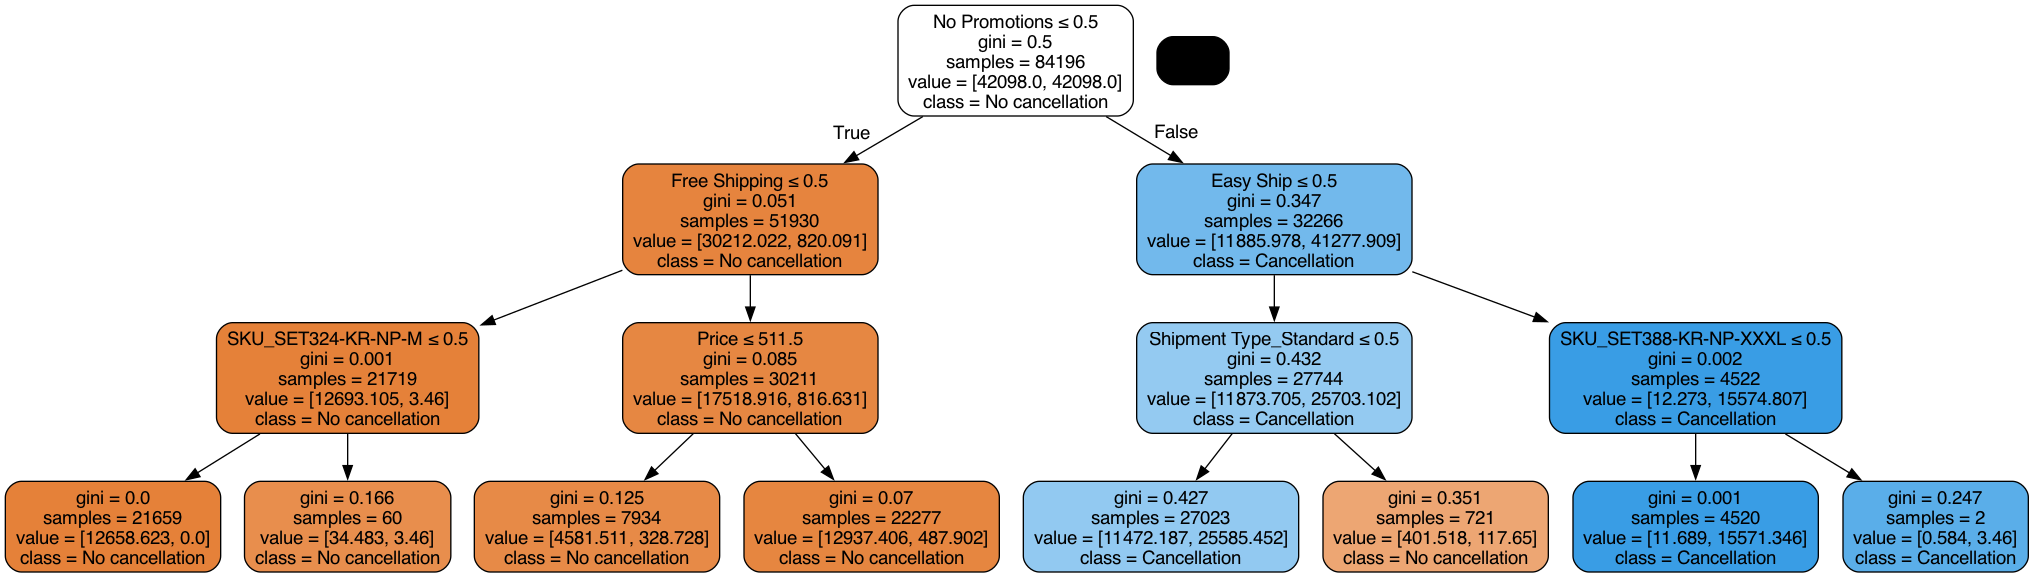

In [12]:
dot_data = StringIO()
tree.export_graphviz(gini_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=pd.DataFrame(X_train).columns,class_names = ["No cancellation", "Cancellation"])

# Alternatively for class_names use gini_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Both Decision tree models produced better results than Logistic regression. The recall for 'Cancelled' class is 98%. The recall for 'Shipped' status (73%) is lower than in Logistic Regression (77%). If we don't have shortage of resources to contact all false positives, then we should choose Decision tree as our base model. Now I will focus on optimizing the model.

## Bayesian optimization

In [34]:
# Defining the function to optimize using cross-validation
def dtree_cv(max_depth, min_samples_split, min_samples_leaf, criterion_index, max_features_index, max_leaf_nodes):
    
    # Mapping the numerical indices back to categorical parameters
    criterion = ['gini', 'entropy'][int(criterion_index)]
    max_features_options = ['sqrt', 'log2', None]
    max_features = max_features_options[int(max_features_index)]
   
    # Defining the model with the parameters to be optimized
    estimator = tree.DecisionTreeClassifier(class_weight = 'balanced',
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        criterion=criterion,
        max_features=max_features,
        max_leaf_nodes=int(max_leaf_nodes)
    )
    
    # Using StratifiedKFold for cross-validation to handle imbalanced classes
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cval = cross_val_score(estimator, X_train_unscaled, y_train, scoring='recall', cv=skf)
    
    return cval.mean()

# Defining the parameter bounds
param_bounds = {
    'max_depth': (1, 20),
    'min_samples_split': (2, 100),
    'min_samples_leaf': (1, 100),
    'criterion_index': (0, 1),  # Index for criterion (0 = 'gini', 1 = 'entropy')
    'max_features_index': (0, 2),  # Index for max_features
    'max_leaf_nodes': (10, 100)
}

optimizer = BayesianOptimization(
    f=dtree_cv,
    pbounds=param_bounds,
    random_state=1,
)

optimizer.maximize(n_iter=25, init_points=5) # Bayesian optimization

# Extracting the best parameters
best_params_bayes = optimizer.max['params']
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth'])
best_params_bayes['min_samples_split'] = int(best_params_bayes['min_samples_split'])
best_params_bayes['min_samples_leaf'] = int(best_params_bayes['min_samples_leaf'])
best_params_bayes['max_leaf_nodes'] = int(best_params_bayes['max_leaf_nodes'])

# Mapping back the categorical indices to their original values
best_params_bayes['criterion'] = ['gini', 'entropy'][int(best_params_bayes['criterion_index'])]
max_features_options = ['sqrt', 'log2', None]
best_params_bayes['max_features'] = max_features_options[int(best_params_bayes['max_features_index'])]

# Removing the indices from best_params_bayes dictionary
del best_params_bayes['criterion_index']
del best_params_bayes['max_features_index']

best_score_bayes = optimizer.max['target']

print(f"Best Parameters (Bayesian Optimization): {best_params_bayes}")
print(f"Best Score (Bayesian Optimization): {best_score_bayes}")

|   iter    |  target   | criter... | max_depth | max_fe... | max_le... | min_sa... | min_sa... |
-------------------------------------------------------------------------------------------------
| 1         | 0.6909    | 0.417     | 14.69     | 0.0002287 | 37.21     | 15.53     | 11.05     |
| 2         | 0.4925    | 0.1863    | 7.566     | 0.7935    | 58.49     | 42.5      | 69.15     |
| 3         | 0.7302    | 0.2045    | 17.68     | 0.05478   | 70.34     | 42.31     | 56.75     |
| 4         | 0.2958    | 0.1404    | 4.764     | 1.601     | 97.14     | 32.03     | 69.85     |
| 5         | 0.7735    | 0.8764    | 18.0      | 0.1701    | 13.51     | 17.81     | 88.06     |
| 6         | 0.8535    | 0.8778    | 18.7      | 0.5232    | 14.22     | 18.52     | 88.41     |
| 7         | 0.6766    | 0.8856    | 20.0      | 1.962     | 17.08     | 21.38     | 89.85     |
| 8         | 0.7235    | 0.0       | 20.0      | 0.0       | 14.28     | 20.53     | 85.8      |
| 9         | 0.7133

## Creating final model

In [8]:
best_model = tree.DecisionTreeClassifier(class_weight = 'balanced',
                                         max_depth=20,
                                         criterion="entropy",
                                         max_leaf_nodes=12,
                                         min_samples_leaf=19,
                                         min_samples_split=90)

best_model.fit(X_train_unscaled, y_train)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_model_cv_results = cross_validate(best_model, X_train_unscaled, y_train, cv=skf)

y_pred6 = best_model.predict(X_test_unscaled) 
y_pred6 = pd.Series(y_pred6)

cr6 = classification_report(y_test, y_pred6)
print('Classification report:')
print(cr6)

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     31007
           1       0.37      0.98      0.54      5077

    accuracy                           0.76     36084
   macro avg       0.68      0.85      0.69     36084
weighted avg       0.91      0.76      0.80     36084



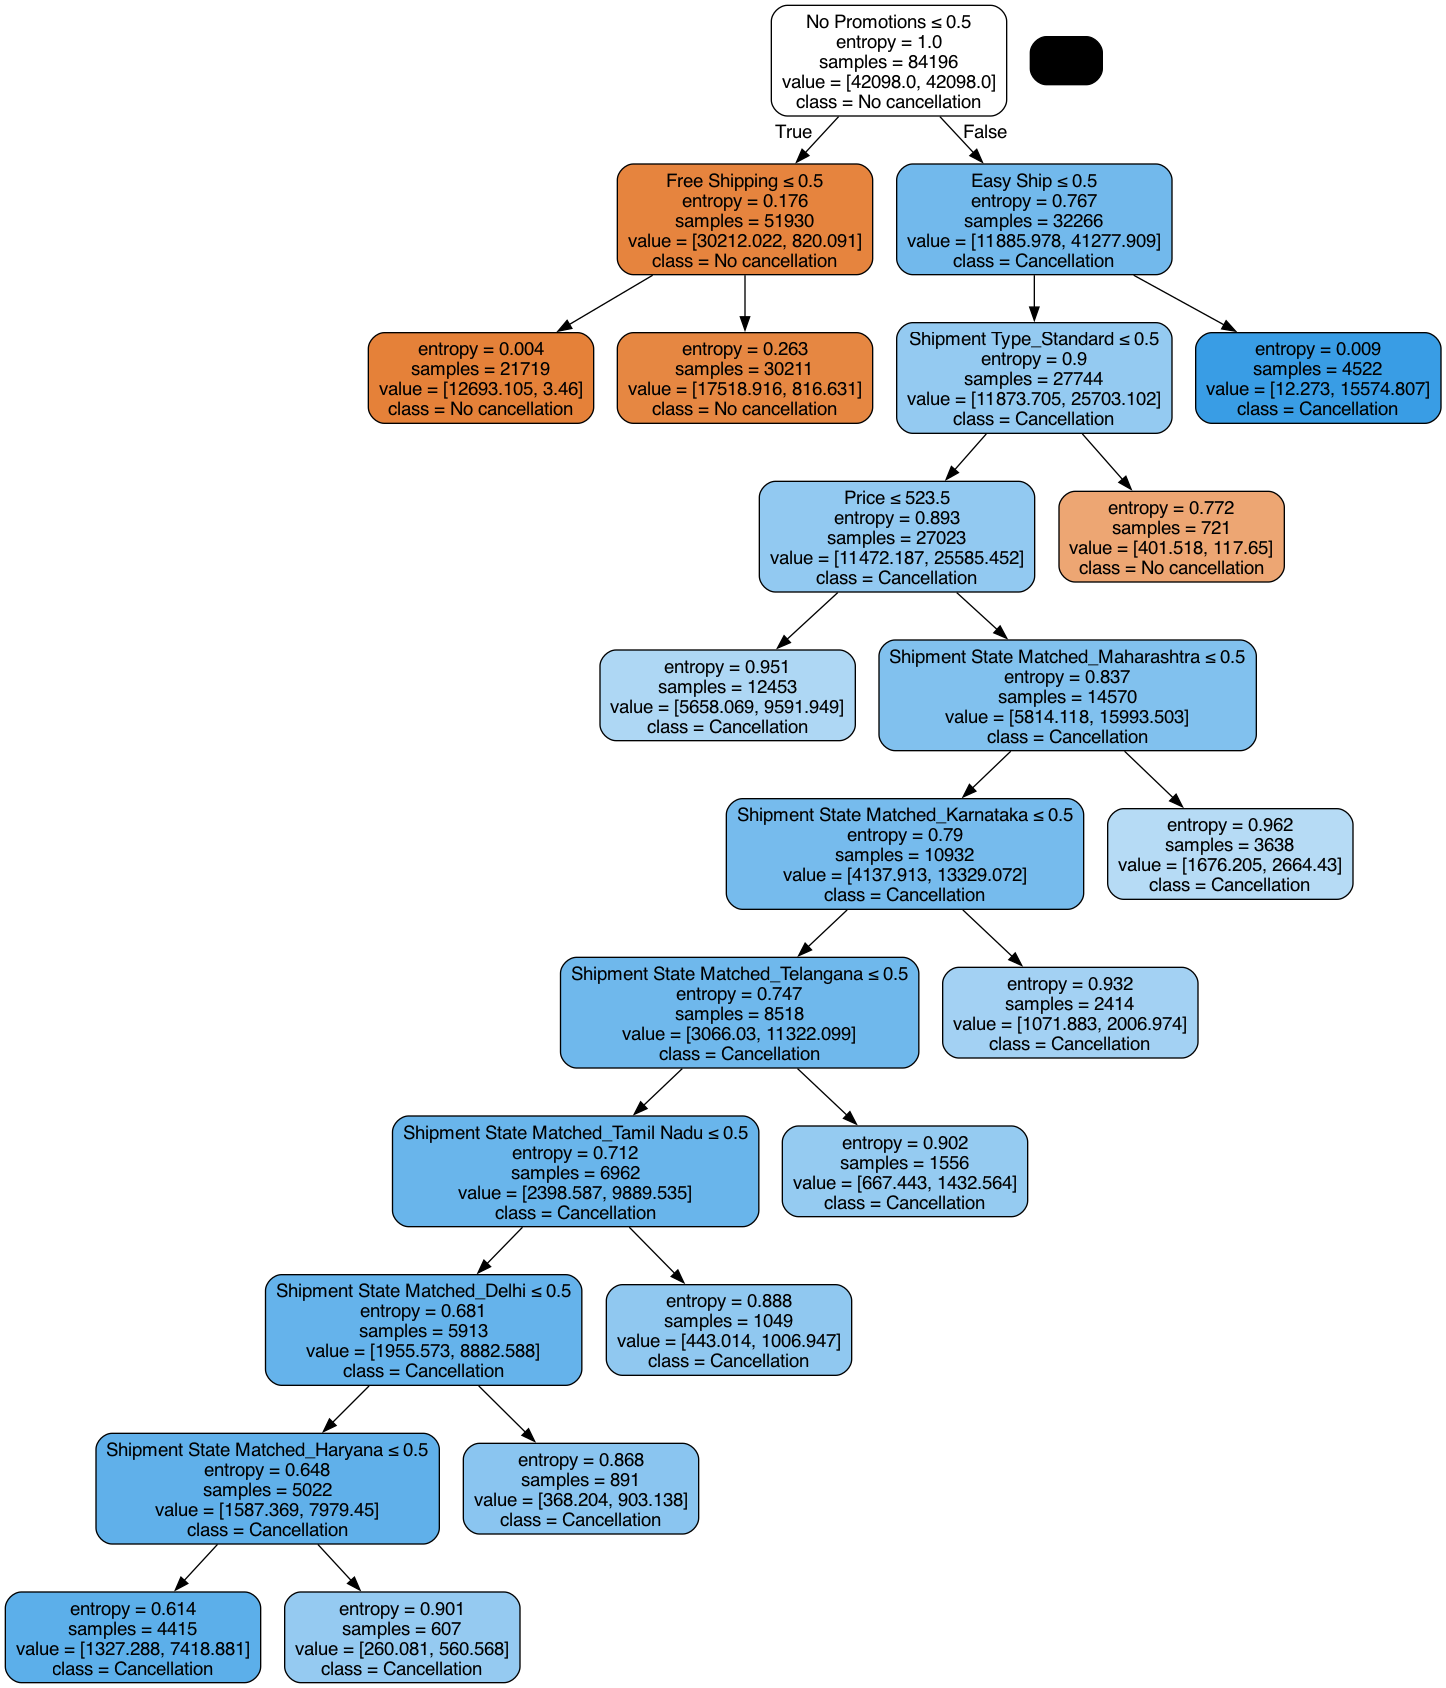

In [40]:
# Visualizing the tree
dot_data2 = StringIO()
tree.export_graphviz(best_model, out_file=dot_data2,  
                filled=True, rounded=True,
                special_characters=True, feature_names=pd.DataFrame(X_train).columns,class_names = ["No cancellation", "Cancellation"])

# Alternatively for class_names use gini_model.classes_
graph2 = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph2.create_png())

The model is deciding between 'Cancellation' and 'No Cancellation' mostly based on 'No Promotions' feature - if product was bought with no promotions it's most likely to be returned, unless the shipment type was not 'Standard' (so, 'Expedited' shipment) - in this case it's more likely that customer will keep it.

In [9]:
# Saving basic info about model
best_model.version = 1
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [10]:
# saving the model

modelpath = '../models'
save_file(best_model, 'decision_tree_cancellations.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models/decision_tree_cancellations.pkl"
